# Variational Bayesian Last Layers for Bayesian Optimization

- Contributors: brunzema
- Last updated: Feb 13, 2025
- BoTorch version: 0.9.6(dev), commit hash: dccda59d8ef51d8074de82fdb5614bad2db0ee96 UPDATE!

In this notebook, we will demonstrate how to use variational Bayesian last layers (VBLLs) for Bayesian optimization [1, 2].

[1] P. Brunzema, M. Jordahn, J. Willes, S. Trimpe, J. Snoek, J. Harrison. Bayesian Optimization via Continual Variational Last Layer Training. International Conference on Learning Representations (ICLR), 2025.

[2] J. Harrison, J. Willes, J. Snoek. Variational Bayesian Last Layers. International Conference on Learning Representations (ICLR), 2024.


# Introduction to the VBLL Model

Bayesian optimization (BO) relies on surrogate models that provide uncertainty-aware predictions. Usually, Gaussian processes are the goto choice due to their analytical tractability, but they can limiting for input spaces that are non-Euclidean where careful choise of the kernel is curcial. Here, Bayesian neural networks are promissing as they automatically learn the correlations. 

Variational Bayesian Last Layer (VBLL) [2] models provide a practical and scalable way to approximate Bayesian inference in neural networks. Instead of placing a prior over all network weights, VBLL only model the uncertainty on the parameters on the last layer while keeping the feature extractor deterministic. This setup allows the model to retain the expressive power of deep learning while maintaining well-calibrated uncertainty estimates.

In VBLL, we model the output as a generalized linear model with learned features $\phi_{\theta}$ as:
$$
    y = \mathbf{w}^\top \phi_{\theta} (\mathbf{x}) + \varepsilon
$$
where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$
VBLL models use a variational posterior distribution on the weights as $\mathbf{w} \sim q(\mathbf{w})$ with $q(\mathbf{w}) = \mathcal{N}(\bar{\mathbf{w}}, S)$ where $\bar{\mathbf{w}}$ is the mean and $S$ the full covariance of a multivariate normal distribution.
Through conjugany, we yield the posterior predictive
$$
    p(y \mid \mathbf{x}, \mathcal{D}_T, \theta) = \mathcal{N} \big( \bar{\mathbf{w}}_T^\top \phi_{\theta}(\mathbf{x}), \, \phi_{\theta}(\mathbf{x})^\top S_T \phi_{\theta}(\mathbf{x}) + \sigma^{2} \big).
$$
This predictive can then be used in downsteam tasks such as Bayesian optimization (BO).

## The VBLLs on Toy Data

Before using the VBLL model in the context of Bayesian Optimization, let's see how the interface of the model looks. The current implementation allows for passing a full backbone to the model (which could be anything). If no backbone is provided, a standard MLP is created. For training, [1] discusses continual learning approaches which will be added to the implementation but in the following, we will not go into detail. See the docstring of `model.fit` for the different options for configuring the optimization and the training.

Below, we use the model in a 1D regression example.


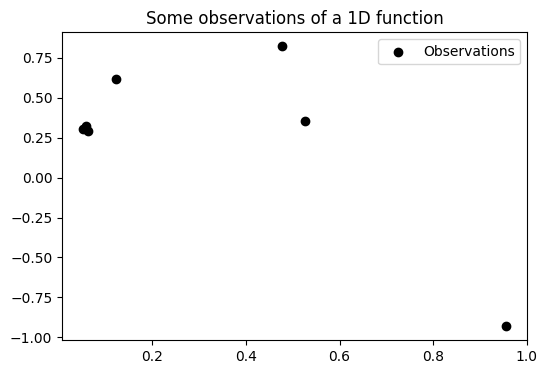

In [1]:
import matplotlib.pyplot as plt
import torch
from botorch_community.models.vblls import VBLLModel

torch.set_default_dtype(torch.float64)
torch.manual_seed(42)


def objective(x, noise=True):
    out = torch.sin(x * 5)
    if noise:
        out += 0.1 * torch.randn_like(x)
    return out


X = torch.rand(7, 1)
Y = objective(X)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_title("Some observations of a 1D function")
ax.scatter(X, Y, c="k", label="Observations")
ax.legend()
plt.show()

In [2]:
model = VBLLModel(
    in_features=1,
    hidden_features=50,
    num_layers=3,
    out_features=1,
)

# lets print the model, we can see the MLP backbone and the VBLL regression head
print(model)

# fit the model on the data -- it is also possible to specify the optimizer throught `optimizer_settings` (see docstring)
model.fit(X, Y)

VBLLNetwork(
  (activation): ELU(alpha=1.0)
  (backbone): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (head): Regression()
)
Early stopping at epoch  6195  with loss  1.0684124442429037


Now we can use the model in the same way as a Gaussian process. Note, below is the exact same code as one would use with a GPyTorch model!


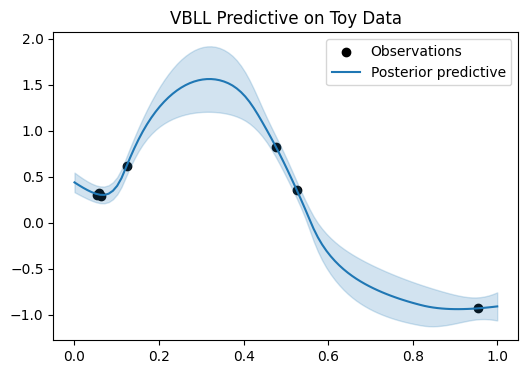

In [3]:
test_X = torch.linspace(0, 1, 100)
with torch.no_grad():
    posterior = model.posterior(test_X.view(-1, 1))
mean, std = posterior.mean.squeeze(), posterior.variance.sqrt().squeeze()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_title("VBLL Predictive on Toy Data")
ax.scatter(X, Y, c="k", label="Observations")
ax.plot(test_X, mean, label="Posterior predictive", color="tab:blue")
ax.fill_between(test_X, mean - 2 * std, mean + 2 * std, alpha=0.2, color="tab:blue")
ax.legend()
plt.show()

## Thompson sampling with VBLLs

VBLLs yield a Gaussian predictive distribution, and thus most acquisition functions that are straightforward to compute for Gaussian Processes (GPs) are also straightforward for VBLLs. Moreover, parametric VBLLs are especially well-suited for Thompson sampling.

For a Thompson sample, we simply sample from the variational posterior of $\mathbf{w}$ at iteration $t$ and then construct a sample from the predictive $\hat{f}$ as a generalized linear model:

\begin{aligned}
&\textcircled{1} \quad \hat{\mathbf{w}} \sim q(\mathbf{w}) \\
&\textcircled{2} \quad \hat{f} (\mathbf{x}) \coloneqq \hat{\mathbf{w}}^\top \phi_{\theta} (\mathbf{x}).
\end{aligned}

We can directly leverage this in BO to choose the next query location as $\mathbf{x}_{t+1} = \arg\max_{\mathbf{x} \in \mathcal{X}} \hat{f} (\mathbf{x})$. Since the sample is a linear model, we can numerically optimize the sample path as we can simply calculate gradients of the sample.


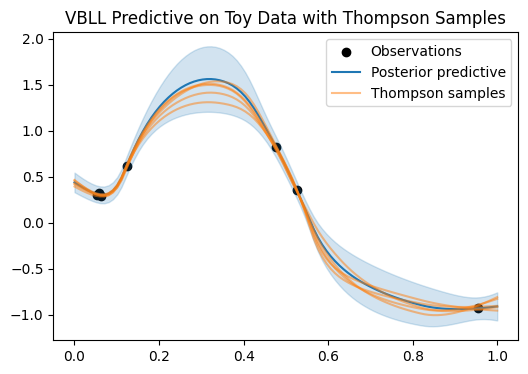

In [4]:
def plot_model(model, x, y, new_data=None, show_opjective=False):
    x_test = torch.linspace(0, 1, 100)
    with torch.no_grad():
        posterior = model.posterior(x_test.view(-1, 1))
    mean, std = posterior.mean.squeeze(), posterior.variance.sqrt().squeeze()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    ax.set_title("VBLL Predictive on Toy Data with Thompson Samples")
    ax.scatter(x, y, c="k", label="Observations")

    if new_data is not None:
        x_new, y_new = new_data
        ax.scatter(x_new, y_new, c="r", label="New observations")

    if show_opjective:
        ax.plot(x_test, objective(x_test, noise=False), label="Objective", color="k")

    ax.plot(x_test, mean, label="Posterior predictive", color="tab:blue")

    # Posterior samples
    with torch.no_grad():
        for i in range(5):
            ts_sample = model.sample()  # a sample is essentially a standard MLP (one can also generate multiple samples, see function)
            ts_mean = ts_sample(x_test.view(-1, 1)).squeeze()
            ax.plot(
                x_test,
                ts_mean,
                color="tab:orange",
                alpha=0.5,
                label="Thompson samples" if i == 0 else None,
            )

    ax.fill_between(x_test, mean - 2 * std, mean + 2 * std, alpha=0.2, color="tab:blue")
    ax.legend()
    plt.show()


plot_model(model, X, Y)

# Bayesian optimization with VBLLs


Next, lets us the VBLLs for Bayesian optimization to optimize the toy function above using Thompson sampling. Note that setting up the Thompson sampling is similar to the standard `MaxPosteriorSampling` in BoTorch.

Iteration 0) 	 Best Value: 0.3324226803440067
Early stopping at epoch  3537  with loss  8.284433330961363


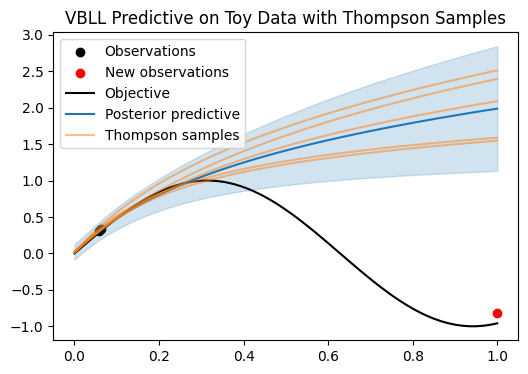

Iteration 1) 	 Best Value: 0.3324226803440067
Early stopping at epoch  2946  with loss  5.458685157415583


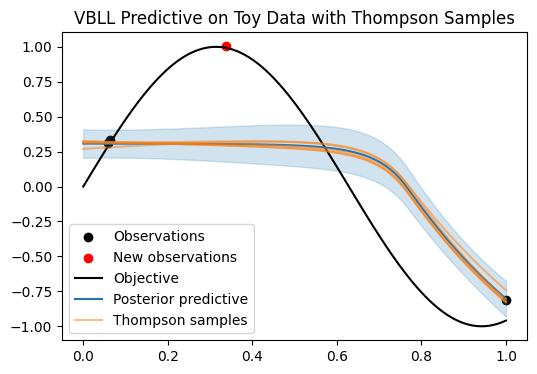

Iteration 2) 	 Best Value: 1.0040176868451611
Early stopping at epoch  5318  with loss  3.4427417449798003


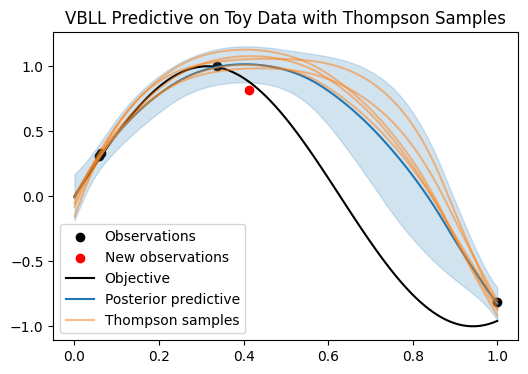

Iteration 3) 	 Best Value: 1.0040176868451611
Early stopping at epoch  3298  with loss  2.7493056257019517


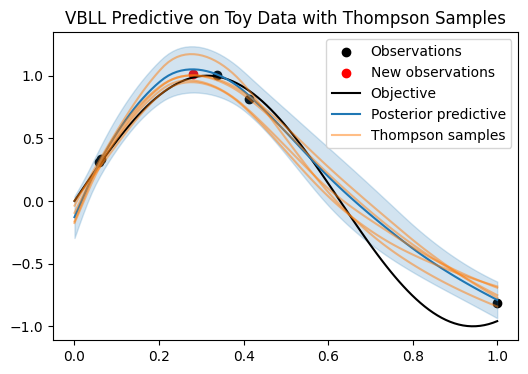

Iteration 4) 	 Best Value: 1.0157966433570296
Early stopping at epoch  4937  with loss  1.7227881954940887


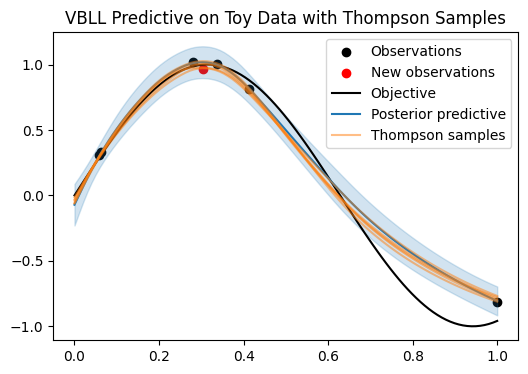

Iteration 5) 	 Best Value: 1.0157966433570296
Early stopping at epoch  4125  with loss  1.548313489101463


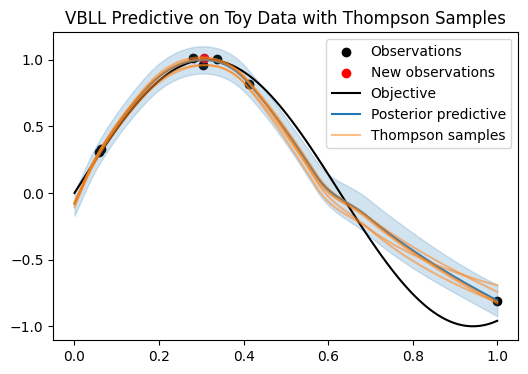

Iteration 6) 	 Best Value: 1.0157966433570296
Early stopping at epoch  10000  with loss  0.8870515445169387


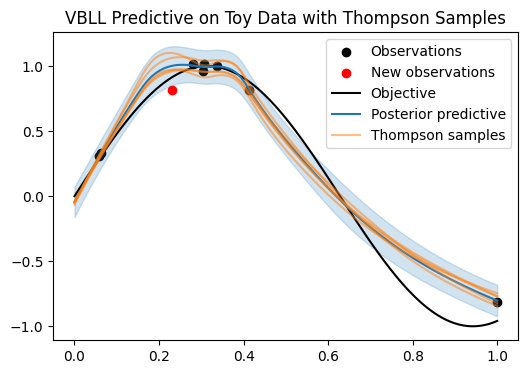

Iteration 7) 	 Best Value: 1.0157966433570296
Early stopping at epoch  7657  with loss  0.4598584669936603


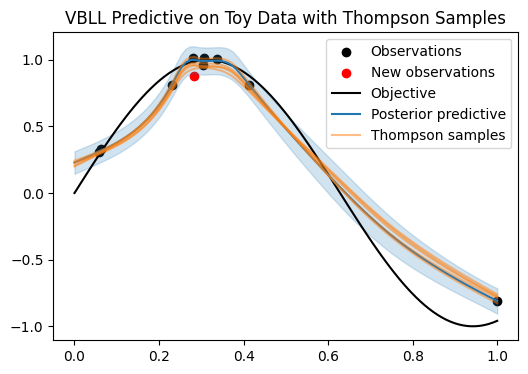

Iteration 8) 	 Best Value: 1.0157966433570296
Early stopping at epoch  3835  with loss  0.6742690267810687


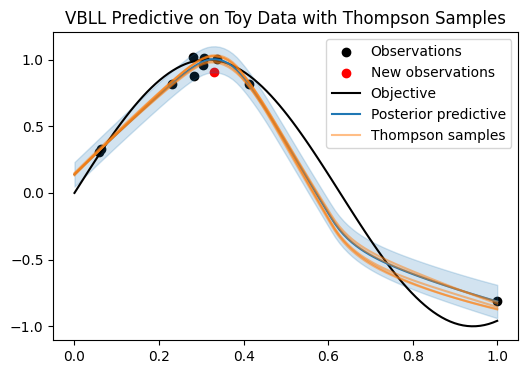

Iteration 9) 	 Best Value: 1.0157966433570296
Early stopping at epoch  7895  with loss  0.40178305739913567


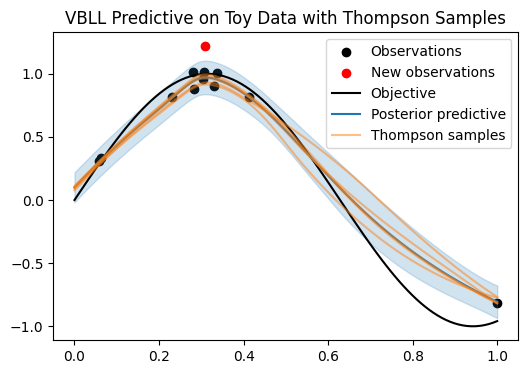

In [5]:
from botorch_community.acquisition.bll_thompson_sampling import BLLMaxPosteriorSampling

batch_size = 1

torch.manual_seed(42)
X_bo = torch.rand(2, 1)
Y_bo = objective(X_bo)

# lets define the optimizer settings (the values below are the default values)
optimizer_settings = {
    "num_epochs": 10_000,  # number of epochs
    "freeze_backbone": False,  # whether to freeze the backbone / features during training
    "patience": 100,  # patience for early stopping (if no improvement for `patience` epochs, stop training)
    "batch_size": 32,  # mini-batch size
    "optimizer": torch.optim.AdamW,  # optimizer
    "wd": 1e-4,  # weight decay
    "lr": 1e-3,  # learning rate
    "clip_val": 1.0,  # gradient clipping value
}

for iteration in range(10):
    print(f"Iteration {iteration}) \t Best Value: {Y_bo.max().item()}")

    # initialize the model
    model = VBLLModel(
        in_features=1,
        hidden_features=50,
        num_layers=3,
        out_features=1,
    )
    model.fit(X_bo, Y_bo, optimization_settings=optimizer_settings)

    # Thompson sampling as acquisition function
    thompson_sampling = BLLMaxPosteriorSampling(
        model=model,
        num_restarts=10,
    )
    X_next = thompson_sampling(num_samples=batch_size)

    # evaluate the objective
    Y_next = objective(X_next)

    # plot the model, the thompson samples and the objective
    plot_model(model, X_bo, Y_bo, new_data=(X_next, Y_next), show_opjective=True)

    # update the data
    X_bo = torch.cat([X_bo, X_next])
    Y_bo = torch.cat([Y_bo, Y_next])

Lets plot the performance over the number of iterations.

/var/folders/b7/4sbb97gd7xdcbjt2mww_cxcr0000gn/T/ipykernel_73018/3219396719.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  best_value = np.maximum.accumulate(obs)


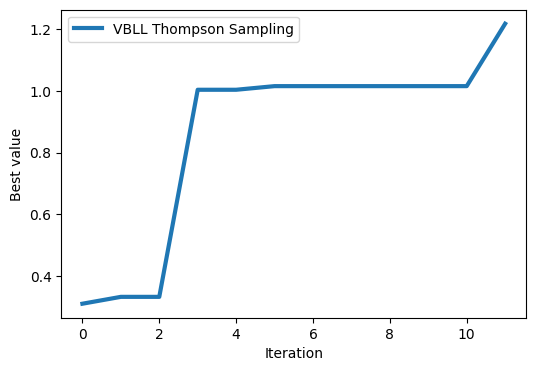

In [6]:
import numpy as np


def plot_performance(observations, labels):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

    for obs, label in zip(observations, labels):
        best_value = np.maximum.accumulate(obs)
        ax.plot(best_value, marker="", lw=3, label=label)

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best value")
    ax.legend()
    plt.show()


plot_performance([Y_bo], labels=["VBLL Thompson Sampling"])

# Bayesian optimization on Ackley2D

Lastly, lets also run Thompson sampling with VBLLs on the standard benchmark Ackley. Parts of the code are copied from the TuRBO tutorial.

In [7]:
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(device=device)
    return X_init


fun = Ackley(dim=2, negate=True)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))


batch_size = 1
n_init = dim * 2
max_cholesky_size = float("inf")  # Always use Cholesky

X_bo = get_initial_points(dim, n_init)
Y_bo = torch.tensor([eval_objective(x) for x in X_bo], device=device).unsqueeze(-1)

for iteration in range(30):
    print(f"Iteration {iteration}) \t Best Value: {Y_bo.max().item()}")

    # initialize the model
    model = VBLLModel(
        in_features=dim,
        hidden_features=50,
        num_layers=3,
        out_features=1,
        device=device,
    )

    # we can also only change part of the optimizer settings, the rest will be the default values
    optimizer_settings = {
        "lr": 1.001e-3,  # value only changed for demonstration, default is 1e-3
    }

    model.fit(X_bo, Y_bo, optimization_settings=optimizer_settings)

    # Thompson sampling as acquisition function
    thompson_sampling = BLLMaxPosteriorSampling(
        model=model,
        num_restarts=10,  # define the number of restarts for the optimization
    )
    X_next = thompson_sampling(num_samples=batch_size)

    # evaluate the objective
    Y_next = torch.tensor([eval_objective(x) for x in X_next], device=device).unsqueeze(
        -1
    )

    # update the data
    X_bo = torch.cat([X_bo, X_next])
    Y_bo = torch.cat([Y_bo, Y_next])

Iteration 0) 	 Best Value: -8.450333157127485
Early stopping at epoch  4679  with loss  5.71127556426972
Iteration 1) 	 Best Value: -8.450333157127485
Early stopping at epoch  549  with loss  414.52220814723216
Iteration 2) 	 Best Value: -8.450333157127485
Early stopping at epoch  5071  with loss  3.3508427848898767
Iteration 3) 	 Best Value: -8.450333157127485
Early stopping at epoch  5381  with loss  3.459799186324661
Iteration 4) 	 Best Value: -3.9786451141759156
Early stopping at epoch  4833  with loss  2.6036754003988127
Iteration 5) 	 Best Value: -3.9786451141759156
Early stopping at epoch  7149  with loss  2.3706048504297788
Iteration 6) 	 Best Value: -3.9786451141759156
Early stopping at epoch  6636  with loss  2.2300785975157407
Iteration 7) 	 Best Value: -3.9786451141759156
Early stopping at epoch  7487  with loss  2.2630146130558413
Iteration 8) 	 Best Value: -3.0623108858518546
Early stopping at epoch  5407  with loss  1.1503732474472212
Iteration 9) 	 Best Value: -1.495155

/var/folders/b7/4sbb97gd7xdcbjt2mww_cxcr0000gn/T/ipykernel_73018/3219396719.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  best_value = np.maximum.accumulate(obs)


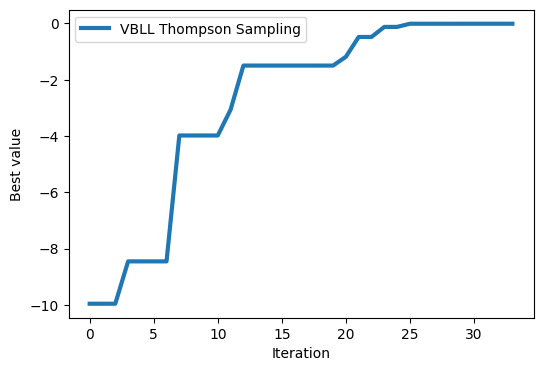

In [8]:
plot_performance([Y_bo], labels=["VBLL Thompson Sampling"])